In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import palettable
from pathlib import Path
import glob
import os
import scipy.ndimage as ndimage
from scipy import signal
import statsmodels.api as smapi
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense, LSTM, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.regularizers import l2
from keras.preprocessing import sequence
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

from keras.optimizers import Adam
from keras.models import load_model
from keras.callbacks import ModelCheckpoint
from time import time

2023-04-14 16:20:16.634945: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-14 16:20:20.609802: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-14 16:20:20.610623: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-14 16:20:59.351589: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
#Specify your data path here
data_dir = Path('/rds/general/user/ys5320/home/Classification')

movements = ['HC_90','HC_45','Leg_extension_sit','Leg_presses_liftup', 'Half_squat']
#movements = ['HC_45','HC_90']

n_move = []
file_path = list()
tcs = list()
target = list()
csv_all = []
for i in range(len(movements)):
    sub_tc = list()
    move = movements[i]
    os.chdir(Path(data_dir, move))
    extension = 'csv'
    csv_filenames = [i for i in glob.glob('*.{}'.format(extension))]
    csv_all.extend(csv_filenames)
    n_move.append(len(csv_filenames))
    file_path.extend(csv_filenames)

    target.extend(i for j in range(n_move[i]))

    for k in range(n_move[i]):
        df = pd.read_csv(csv_filenames[k], index_col = False, header = None)
        values = np.array(df.values)
        values = values[:5700,:]
        #print(values.shape)
        sub_tc.append(values)
        
    tcs.extend(sub_tc)   

In [3]:
stacked_arr = np.stack([arr for arr in tcs])
stacked_arr.shape

(271, 5700, 12)

In [9]:
from sklearn.model_selection import train_test_split
X = stacked_arr
y = np.array(target)
X_train, X_test, y_train, y_test = train_test_split(X,y, stratify = y, test_size = 0.2)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(216, 5700, 12) (55, 5700, 12) (216,) (55,)


In [10]:
y_test.shape

(55,)

In [11]:
import keras
from tensorflow.keras import layers
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

In [12]:
def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(n_classes, activation="softmax")(x)
    return keras.Model(inputs, outputs)

In [13]:
input_shape = X_train.shape[1:]
n_classes = y.max() + 1
model = build_model(
    input_shape,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25,
)

model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=6e-5),
    metrics=["sparse_categorical_accuracy"],
)
model.summary()

callbacks = [keras.callbacks.ModelCheckpoint(
        "transformer_best_model.h5", save_best_only=True, monitor="val_acc",
        save_freq = 120
                              ),
             keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 5700, 12)]   0           []                               
                                                                                                  
 layer_normalization_8 (LayerNo  (None, 5700, 12)    24          ['input_2[0][0]']                
 rmalization)                                                                                     
                                                                                                  
 multi_head_attention_4 (MultiH  (None, 5700, 12)    52236       ['layer_normalization_8[0][0]',  
 eadAttention)                                                    'layer_normalization_8[0][0]']  
                                                                                            

In [14]:
history = model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    epochs=60,
    batch_size=32,
    callbacks=callbacks,
)

model.evaluate(X_test, y_test, verbose=1)

Epoch 1/60
6/6 [==============================] - 526s 78s/step - loss: 6.5078 - sparse_categorical_accuracy: 0.4012 - val_loss: 1.8458 - val_sparse_categorical_accuracy: 0.5455
Epoch 2/60
6/6 [==============================] - 476s 79s/step - loss: 3.0301 - sparse_categorical_accuracy: 0.5988 - val_loss: 1.6222 - val_sparse_categorical_accuracy: 0.6364
Epoch 3/60
6/6 [==============================] - 511s 85s/step - loss: 1.4447 - sparse_categorical_accuracy: 0.7442 - val_loss: 0.8468 - val_sparse_categorical_accuracy: 0.7955
Epoch 4/60
6/6 [==============================] - 468s 78s/step - loss: 0.8975 - sparse_categorical_accuracy: 0.7965 - val_loss: 0.6270 - val_sparse_categorical_accuracy: 0.7955
Epoch 5/60
6/6 [==============================] - 505s 85s/step - loss: 1.0134 - sparse_categorical_accuracy: 0.8023 - val_loss: 0.5726 - val_sparse_categorical_accuracy: 0.7955
Epoch 6/60
6/6 [==============================] - 533s 88s/step - loss: 0.4704 - sparse_categorical_accuracy: 

[0.6599761843681335, 0.9090909361839294]

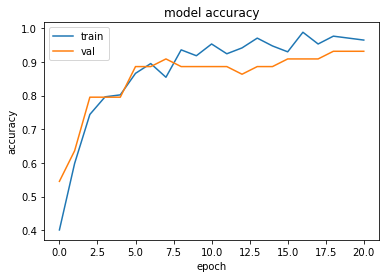

In [15]:
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

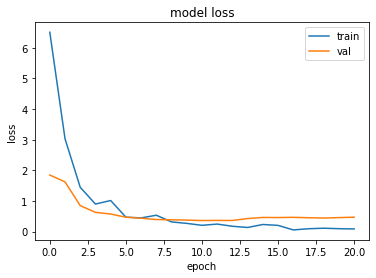

In [16]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [17]:
y_pred = model.predict(X_test)

2/2 [==============================] - 59s 22s/step


In [18]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(y_test, y_pred.argmax(axis = 1))
matrix

array([[11,  1,  0,  0,  0],
       [ 1, 10,  0,  1,  1],
       [ 0,  0,  6,  0,  0],
       [ 0,  0,  0, 12,  0],
       [ 0,  0,  0,  1, 11]])

In [19]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred.argmax(axis = 1)))

              precision    recall  f1-score   support

           0       0.92      0.92      0.92        12
           1       0.91      0.77      0.83        13
           2       1.00      1.00      1.00         6
           3       0.86      1.00      0.92        12
           4       0.92      0.92      0.92        12

    accuracy                           0.91        55
   macro avg       0.92      0.92      0.92        55
weighted avg       0.91      0.91      0.91        55



In [20]:
from pretty_confusion_matrix import pp_matrix

ERROR! Session/line number was not unique in database. History logging moved to new session 25


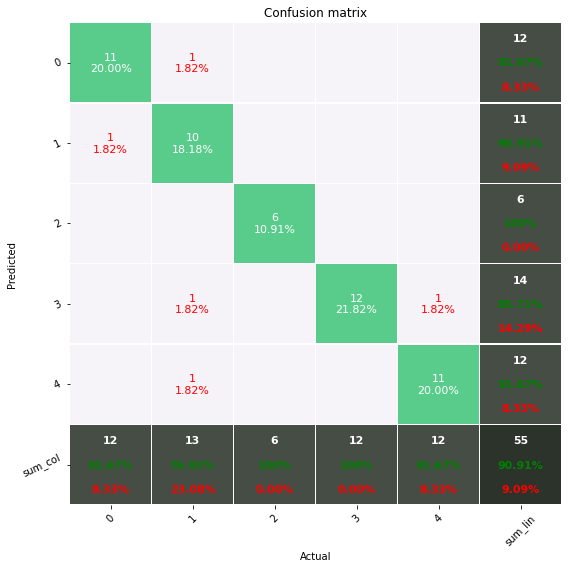

In [22]:
df_cm = pd.DataFrame(matrix)
# colormap: see this and choose your more dear
cmap = 'PuRd'
pp_matrix(df_cm, cmap=cmap)

In [ ]:
df_confusion = pd.DataFrame(matrix, index = movements, columns=movements)
df_confusion['TOTAL'] = df_confusion.sum(axis=1)
df_confusion.loc['TOTAL']= df_confusion.sum()

# get percentages
df_percentages = df_confusion.div(df_confusion.TOTAL, axis=0)
df_percentages.TOTAL = 0

plt.figure(figsize=(24, 10))
                        
sns.set(font_scale = 1.5)

# cmap using data for color, taking values from annot
ax = sns.heatmap(data=df_percentages, annot=df_confusion, cmap='Blues', fmt="d",
                 cbar_kws={'label': 'percentages'})  
  
ax.set_title('Confusion Matrix\n\n',size=22)
ax.set_xlabel('\nPredicted Values',size=20)
ax.set_ylabel('Actual Values ', size=20)

ERROR! Session/line number was not unique in database. History logging moved to new session 26


ERROR! Session/line number was not unique in database. History logging moved to new session 27
